# ISOMAP for dimension reduction

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap, trustworthiness
from sklearn.metrics import pairwise_distances

from scipy.stats import spearmanr

file_path_raw = "../../cleaned_data/joueurs_ligue1_2024_2025_clean_raw.csv"
file_path_per90 = "../../cleaned_data/joueurs_ligue1_2024_2025_clean_per90.csv"
file_path_custom = "../../cleaned_data/joueurs_ligue1_2024_2025_clean_custom.csv"
file_path_custom_GK = "../../cleaned_data/joueurs_ligue1_2024_2025_clean_custom_GK.csv"

data_raw = pd.read_csv(file_path_raw, encoding="utf-8")
data_per90 = pd.read_csv(file_path_per90, encoding="utf-8")
data_custom = pd.read_csv(file_path_custom, encoding="utf-8")
print(data_raw.columns)

Index(['equipe', 'player_id', 'player_name', 'player_country_code', 'age',
       'positions', 'matches_played', 'min', 'gls', 'ast',
       ...
       'second_yellow_cards', 'fls_com', 'fls_drawn', 'offside', 'pk_won',
       'pk_conceded', 'og', 'ball_recov', 'air_dual_won', 'air_dual_lost'],
      dtype='object', length=106)


### Pre-processing : remove non numeric columns, normalize as ISOMap is based on distances between points

In [9]:
def preprocessing(data):
    player_names = data['player_name']
    player_positions = data['positions']
    data_num = data.select_dtypes(include=[np.number]).dropna(axis=1, how='any')
    data_num.index = player_names
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_num)

    removed_cols = set(data.columns) - set(data_num.columns)
    print(f"Columns removed ({len(removed_cols)}): {sorted(list(removed_cols))}")
    
    return X_scaled, data_num.columns, player_positions

X_raw, cols_raw, player_positions_raw = preprocessing(data_raw)
X_per90, cols_per90, player_positions_per90 = preprocessing(data_per90)
X_custom, cols_custom, player_positions_custom = preprocessing(data_custom)

Columns removed (5): ['equipe', 'player_country_code', 'player_id', 'player_name', 'positions']
Columns removed (5): ['equipe', 'player_country_code', 'player_id', 'player_name', 'positions']
Columns removed (5): ['equipe', 'player_country_code', 'player_id', 'player_name', 'positions']


### Results Analysis

=== Raw data ===
Spearman distance correlation: 0.9430
Trustworthiness: 0.9687
Continuity: 0.9906
MRRE: 0.2977


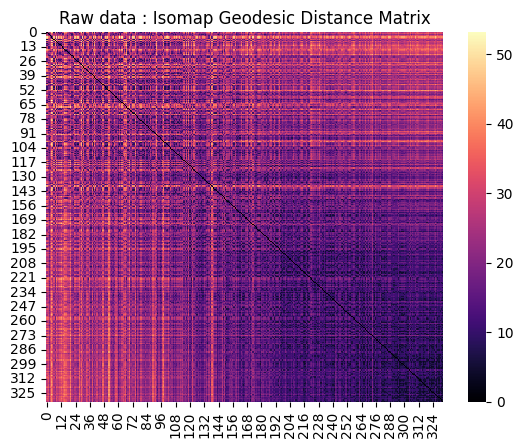


=== Data per 90 min ===
Spearman distance correlation: 0.8921
Trustworthiness: 0.9591
Continuity: 0.9898
MRRE: 0.3565


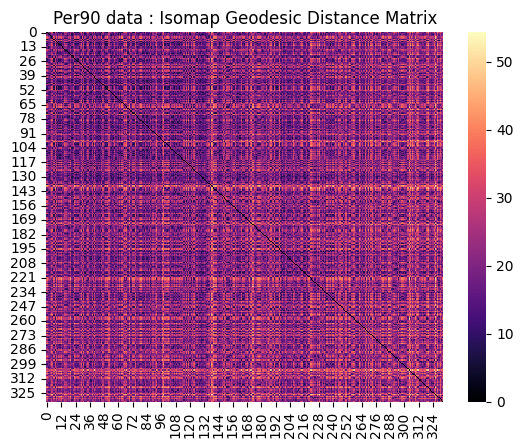


=== Data Custom ===
Spearman distance correlation: 0.8929
Trustworthiness: 0.9468
Continuity: 0.9891
MRRE: 0.3864


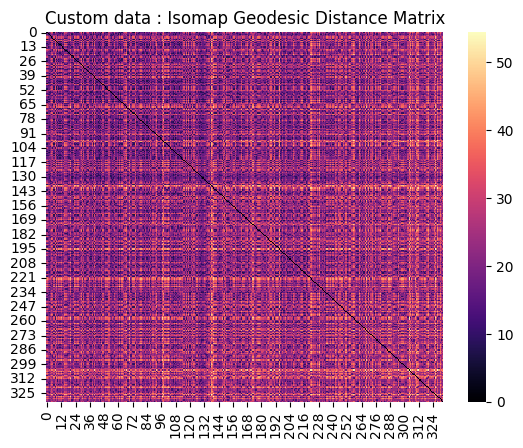


=== Comparisons between both datasets : ===
Similarity of 5 closest neighbors btw both datasets (in %) : 0.3771771771771772


In [12]:
# Continuity
def continuity(X, X_embedded, k):
    n = X.shape[0]
    original_neighbors = np.argsort(pairwise_distances(X), axis=1)[:, 1:k+1]
    embedded_neighbors = np.argsort(pairwise_distances(X_embedded), axis=1)[:, 1:k+1]
    
    total = 0
    for i in range(n):
        orig = set(original_neighbors[i])
        emb = set(embedded_neighbors[i])
        missing = orig - emb
        total += sum([list(original_neighbors[i]).index(m) + 1 for m in missing])
    continuity_score = 1 - (2 / (n * k * (2 * n - 3 * k - 1))) * total
    return continuity_score

# MRRE (Mean Relative Rank Error)
def mrre(X, X_embedded, k):
    n = X.shape[0]
    D_high = pairwise_distances(X)
    D_low = pairwise_distances(X_embedded)

    R_high = np.argsort(np.argsort(D_high, axis=1), axis=1)
    R_low = np.argsort(np.argsort(D_low, axis=1), axis=1)

    error = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                error += abs(R_high[i][j] - R_low[i][j]) / R_high[i][j]
    return error / (n * (n - 1))

def extractMetrics(iso, data, data_iso, k=10) : 
    kernel_matrix = iso.dist_matrix_  #geodesic distance btw players
    shape = iso.embedding_.shape      #nb players / nb dim

    # pairwise distance
    D_high = pairwise_distances(data)
    D_low = pairwise_distances(data_iso)
    corr, _ = spearmanr(D_high[np.triu_indices_from(D_high, k=1)], D_low[np.triu_indices_from(D_low, k=1)])

    trust = trustworthiness(data, data_iso, n_neighbors=k)
    cont = continuity(data, data_iso, k)
    mrre_score = mrre(data, data_iso, k)

    # relative Variance per dimension :
    variances = np.var(data_iso, axis=0)
    explained_like_ratio = variances / np.sum(variances)

    return kernel_matrix, shape, corr, explained_like_ratio, trust, cont, mrre_score

def compare_neighbors(kernel1, kernel2, k=5):
    idx1 = np.argsort(kernel1, axis=1)[:, 1:k+1]
    idx2 = np.argsort(kernel2, axis=1)[:, 1:k+1]
    return np.mean([len(set(i1).intersection(i2)) / k for i1, i2 in zip(idx1, idx2)])



kernel_raw, shape_raw, corr_raw, var_ratio_raw, trust_raw, cont_raw, mrre_raw = extractMetrics(iso_raw, X_raw, X_iso_raw)
kernel_per90, shape_per90, corr_per90, var_ratio_per90, trust_per90, cont_per90, mrre_per90 = extractMetrics(iso_per90, X_per90, X_iso_per90)
kernel_custom, shape_custom, corr_custom, var_ratio_custom, trust_custom, cont_custom, mrre_custom = extractMetrics(iso_custom, X_custom, X_iso_custom)
neighbor_stability = compare_neighbors(kernel_raw, kernel_per90)

print("=== Raw data ===")
print(f"Spearman distance correlation: {corr_raw:.4f}")
print(f"Trustworthiness: {trust_raw:.4f}")
print(f"Continuity: {cont_raw:.4f}")
print(f"MRRE: {mrre_raw:.4f}")
# Geodesic distances analysis
sns.heatmap(kernel_raw, cmap="magma")
plt.title("Raw data : Isomap Geodesic Distance Matrix")
plt.show()

print("\n=== Data per 90 min ===")
print(f"Spearman distance correlation: {corr_per90:.4f}")
print(f"Trustworthiness: {trust_per90:.4f}")
print(f"Continuity: {cont_per90:.4f}")
print(f"MRRE: {mrre_per90:.4f}")
# Geodesic distances analysis
sns.heatmap(kernel_per90, cmap="magma")
plt.title("Per90 data : Isomap Geodesic Distance Matrix")
plt.show()

print("\n=== Data Custom ===")
print(f"Spearman distance correlation: {corr_custom:.4f}")
print(f"Trustworthiness: {trust_custom:.4f}")
print(f"Continuity: {cont_custom:.4f}")
print(f"MRRE: {mrre_custom:.4f}")
# Geodesic distances analysis
sns.heatmap(kernel_custom, cmap="magma")
plt.title("Custom data : Isomap Geodesic Distance Matrix")
plt.show()

print("\n=== Comparisons between both datasets : ===")
print(f"Similarity of 5 closest neighbors btw both datasets (in %) : {neighbor_stability}")

### GridSearch analysis of hyperparameters of ISOMap

In [36]:
def grid_search_isomap(data_raw, data_per90, data_custom, n_neighbors_list, n_components_list):
    results_raw = []
    results_per90 = []
    results_custom = []
    results_stability = []
    

    for n_neighbors in n_neighbors_list:
        for n_components in n_components_list:
            iso_raw = Isomap(n_neighbors=n_neighbors, n_components=n_components)
            iso_per90 = Isomap(n_neighbors=n_neighbors, n_components=n_components)
            iso_custom = Isomap(n_neighbors=n_neighbors, n_components=n_components)
            data_iso_raw = iso_raw.fit_transform(data_raw)
            data_iso_per90 = iso_per90.fit_transform(data_per90)
            data_iso_custom = iso_custom.fit_transform(data_custom)
            kernel_raw, shape_raw, corr_raw, var_ratio_raw, trust_raw, cont_raw, mrre_raw = extractMetrics(iso_raw, data_raw, data_iso_raw)
            kernel_per90, shape_per90, corr_per90, var_ratio_per90, trust_per90, cont_per90, mrre_per90 = extractMetrics(iso_per90, data_per90, data_iso_per90)
            kernel_custom, shape_custom, corr_custom, var_ratio_custom, trust_custom, cont_custom, mrre_custom = extractMetrics(iso_custom, data_custom, data_iso_custom)
            
            results_raw.append({
                "n_neighbors": n_neighbors,
                "n_components": n_components,
                "dist_corr": corr_raw,
                "trustworthiness": trust_raw,
                "continuity": cont_raw,
                "MRRE": mrre_raw
            })
            results_per90.append({
                "n_neighbors": n_neighbors,
                "n_components": n_components,
                "dist_corr": corr_per90,
                "trustworthiness": trust_per90,
                "continuity": cont_per90,
                "MRRE": mrre_per90
            })
            results_custom.append({
                "n_neighbors": n_neighbors,
                "n_components": n_components,
                "dist_corr": corr_custom,
                "trustworthiness": trust_custom,
                "continuity": cont_custom,
                "MRRE": mrre_custom
            })

            results_stability.append({
                "n_neighbors": n_neighbors,
                "n_components": n_components,
                "neighbours_stability" : compare_neighbors(kernel_raw, kernel_per90)
             })
    
    df_raw = pd.DataFrame(results_raw)
    df_per90 = pd.DataFrame(results_per90)
    df_custom = pd.DataFrame(results_custom)
    df_stability = pd.DataFrame(results_stability)
    return df_raw, df_per90, df_custom, df_stability

neighbors_grid = [10, 15, 20, 25, 30]
components_grid = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# --- Grid search sur les datasets ---
results_raw, results_per90, results_custom, results_stability = grid_search_isomap(X_raw, X_per90, X_custom, neighbors_grid, components_grid)

# --- Affichage des résultats ---
def print_metric_pivot(df, metric_name, title):
    print(f"\n{title} — {metric_name}:")
    display(df.pivot(index="n_neighbors", columns="n_components", values=metric_name))

print("=== Raw data ===")
for metric in ["dist_corr", "trustworthiness", "continuity", "MRRE"]:
    print_metric_pivot(results_raw, metric, "Raw data")

print("\n=== Per90 data ===")
for metric in ["dist_corr", "trustworthiness", "continuity", "MRRE"]:
    print_metric_pivot(results_per90, metric, "Per90 data")

print("\n=== Custom data ===")
for metric in ["dist_corr", "trustworthiness", "continuity", "MRRE"]:
    print_metric_pivot(results_custom, metric, "Custom data")

print("\n=== Neighbour Stability between raw & per90 ===")
print_metric_pivot(results_stability, "neighbours_stability", "Neighbour stability")

=== Raw data ===

Raw data — dist_corr:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.877252,0.914058,0.921284,0.930763,0.937541,0.941674,0.945097,0.948315,0.948771
15,0.883497,0.918403,0.926655,0.936195,0.943160,0.945673,0.948371,0.951722,0.953899
20,0.884811,0.920659,0.930840,0.942971,0.948728,0.951974,0.956461,0.959057,0.961049
25,0.892618,0.928373,0.938787,0.947767,0.954263,0.958482,0.960666,0.963762,0.965773
30,0.894530,0.932146,0.943365,0.952838,0.958533,0.961429,0.963864,0.966615,0.968394



Raw data — trustworthiness:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.911643,0.947287,0.959548,0.967923,0.971674,0.973560,0.975193,0.976731,0.977302
15,0.913165,0.949305,0.961303,0.968341,0.973010,0.974462,0.976662,0.979169,0.980295
20,0.916684,0.949465,0.958546,0.968654,0.973641,0.974372,0.977067,0.979235,0.980332
25,0.914326,0.947766,0.962828,0.968581,0.973593,0.976246,0.977016,0.977547,0.978538
30,0.917255,0.950240,0.957273,0.970421,0.974530,0.976921,0.978340,0.979414,0.981544



Raw data — continuity:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.988138,0.989540,0.990203,0.990674,0.991140,0.991462,0.991660,0.991945,0.992219
15,0.988026,0.989531,0.990190,0.990470,0.990909,0.991035,0.991349,0.991680,0.991782
20,0.988133,0.989510,0.989993,0.990596,0.991089,0.991143,0.991330,0.991646,0.991781
25,0.987948,0.989201,0.990162,0.990459,0.990892,0.991058,0.991096,0.991209,0.991329
30,0.987941,0.989352,0.989943,0.990741,0.990877,0.990984,0.991120,0.991419,0.991369



Raw data — MRRE:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.445049,0.366005,0.349176,0.332029,0.323462,0.319423,0.314721,0.309720,0.310543
15,0.424128,0.350536,0.329143,0.312231,0.299799,0.295232,0.286916,0.279635,0.275304
20,0.421513,0.346436,0.323888,0.297706,0.286055,0.281701,0.275205,0.267718,0.264088
25,0.414328,0.337432,0.306417,0.286151,0.274062,0.267771,0.262227,0.258341,0.256267
30,0.412138,0.333343,0.304467,0.277911,0.266227,0.262259,0.255547,0.249616,0.246601



=== Per90 data ===

Per90 data — dist_corr:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.810640,0.831214,0.839106,0.853840,0.867462,0.871785,0.877559,0.883048,0.886324
15,0.815268,0.843259,0.855261,0.867144,0.883813,0.890339,0.890361,0.890960,0.894632
20,0.828373,0.853109,0.868743,0.879904,0.892062,0.892586,0.895565,0.899557,0.904371
25,0.833735,0.858268,0.879990,0.893082,0.900048,0.901378,0.906702,0.910914,0.916664
30,0.837737,0.863392,0.885605,0.897007,0.900732,0.907502,0.913863,0.915236,0.920433



Per90 data — trustworthiness:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.887151,0.923939,0.937240,0.947832,0.954998,0.956000,0.959673,0.961045,0.963886
15,0.885724,0.918996,0.939673,0.949236,0.958066,0.959544,0.958260,0.961475,0.964866
20,0.887778,0.918122,0.938151,0.954113,0.959102,0.959290,0.961541,0.966404,0.967553
25,0.888090,0.914569,0.935057,0.952392,0.954087,0.957993,0.961095,0.963949,0.966456
30,0.887914,0.911093,0.930865,0.949742,0.951987,0.956687,0.962528,0.963942,0.966026



Per90 data — continuity:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.986997,0.988294,0.989021,0.989341,0.989922,0.990040,0.990397,0.990553,0.990735
15,0.987106,0.988144,0.988707,0.989166,0.989546,0.989703,0.989830,0.990159,0.990532
20,0.986964,0.988141,0.988847,0.989533,0.989812,0.989857,0.990094,0.990409,0.990380
25,0.987126,0.988159,0.988641,0.989413,0.989541,0.989818,0.990140,0.990027,0.990249
30,0.987120,0.987829,0.988556,0.989387,0.989599,0.989794,0.990233,0.990148,0.990212



Per90 data — MRRE:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.570688,0.474815,0.438850,0.418281,0.396783,0.390678,0.387895,0.379524,0.375405
15,0.558785,0.470905,0.418869,0.394742,0.372303,0.363500,0.364146,0.358664,0.351851
20,0.545931,0.466741,0.406615,0.376651,0.356523,0.351735,0.345559,0.335029,0.328776
25,0.535227,0.459759,0.397407,0.363599,0.348920,0.341315,0.331893,0.325436,0.319023
30,0.535272,0.465442,0.398046,0.360800,0.352362,0.342458,0.327841,0.328365,0.321428



=== Custom data ===

Custom data — dist_corr:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.809681,0.819424,0.843180,0.848320,0.860383,0.868124,0.872973,0.879616,0.886624
15,0.820936,0.844775,0.861402,0.868349,0.880676,0.886845,0.892800,0.895729,0.899985
20,0.825880,0.855731,0.873052,0.878329,0.887921,0.893476,0.900456,0.903405,0.906519
25,0.825971,0.861757,0.879352,0.883451,0.892917,0.899375,0.905226,0.907809,0.914252
30,0.827908,0.864629,0.880959,0.885389,0.897623,0.904007,0.909325,0.914287,0.916896



Custom data — trustworthiness:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.880331,0.909867,0.927768,0.940297,0.946020,0.951248,0.957149,0.958277,0.959844
15,0.879186,0.913290,0.929430,0.938957,0.945555,0.953365,0.956008,0.959183,0.960267
20,0.880640,0.915090,0.928184,0.941835,0.949224,0.952987,0.957581,0.959256,0.958389
25,0.879345,0.913340,0.928740,0.944374,0.946758,0.954759,0.957312,0.961543,0.964142
30,0.879645,0.915595,0.933269,0.944673,0.949883,0.956712,0.957613,0.961505,0.962739



Custom data — continuity:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.986783,0.987980,0.988608,0.988894,0.989300,0.989518,0.989940,0.990124,0.990196
15,0.986643,0.987883,0.988232,0.988485,0.988895,0.989304,0.989432,0.989559,0.989670
20,0.986844,0.987905,0.988231,0.988748,0.988851,0.989206,0.989376,0.989504,0.989489
25,0.986807,0.987911,0.988303,0.988945,0.989072,0.989319,0.989481,0.989704,0.989845
30,0.986800,0.988011,0.988510,0.988945,0.989189,0.989446,0.989498,0.989685,0.989625



Custom data — MRRE:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.590466,0.512900,0.462970,0.447824,0.427779,0.416902,0.401409,0.396850,0.391296
15,0.572896,0.489776,0.452476,0.433254,0.412743,0.391375,0.386074,0.382503,0.375214
20,0.565126,0.478812,0.440406,0.415197,0.390388,0.376139,0.369365,0.360731,0.356431
25,0.564979,0.473039,0.427874,0.398832,0.386418,0.362713,0.355490,0.348303,0.341045
30,0.560425,0.469492,0.421278,0.391487,0.380257,0.362541,0.356295,0.344597,0.339838



=== Neighbour Stability between raw & per90 ===

Neighbour stability — neighbours_stability:


n_components,2,3,4,5,6,7,8,9,10
n_neighbors,,,,,,,,,
10,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177
15,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177
20,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177
25,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177
30,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177,0.377177


## ISOMap computation of Optimal model

In [11]:
def run_isomap(X, n_components, n_neighbors):
    iso = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    X_iso = iso.fit_transform(X)
        
    return X_iso, iso

X_iso_raw, iso_raw = run_isomap(X_raw, n_components=5, n_neighbors=20)
X_iso_per90, iso_per90 = run_isomap(X_per90, n_components=6, n_neighbors=20)
X_iso_custom, iso_custom = run_isomap(X_custom, n_components=6, n_neighbors=25)

## ISOMap dimension reduction export in csv

In [10]:
def export_isomap(X_iso, data, prefix):
    player_names = data['player_name']
    teams = data['equipe']
    positions = data['positions']

    iso_df = pd.DataFrame(X_iso, columns=[f'isomap_{i+1}' for i in range(X_iso.shape[1])])
    
    iso_df['player_name'] = player_names
    iso_df['equipe'] = teams
    iso_df['positions'] = positions
    
    filename = f"../../reduced_data/joueurs_ligue1_ISOMap_{prefix}.csv"
    iso_df.to_csv(filename, index=False, encoding="utf-8")
    print(f"✅ Exported {filename} ({iso_df.shape[0]} rows, {iso_df.shape[1]} columns)")

export_isomap(X_iso_raw, data_raw, prefix='raw')
export_isomap(X_iso_per90, data_per90, prefix='per90')
export_isomap(X_iso_custom, data_custom, prefix='custom')

✅ Exported ../../reduced_data/joueurs_ligue1_ISOMap_raw.csv (333 rows, 8 columns)
✅ Exported ../../reduced_data/joueurs_ligue1_ISOMap_per90.csv (333 rows, 9 columns)
✅ Exported ../../reduced_data/joueurs_ligue1_ISOMap_custom.csv (356 rows, 9 columns)


### Results display

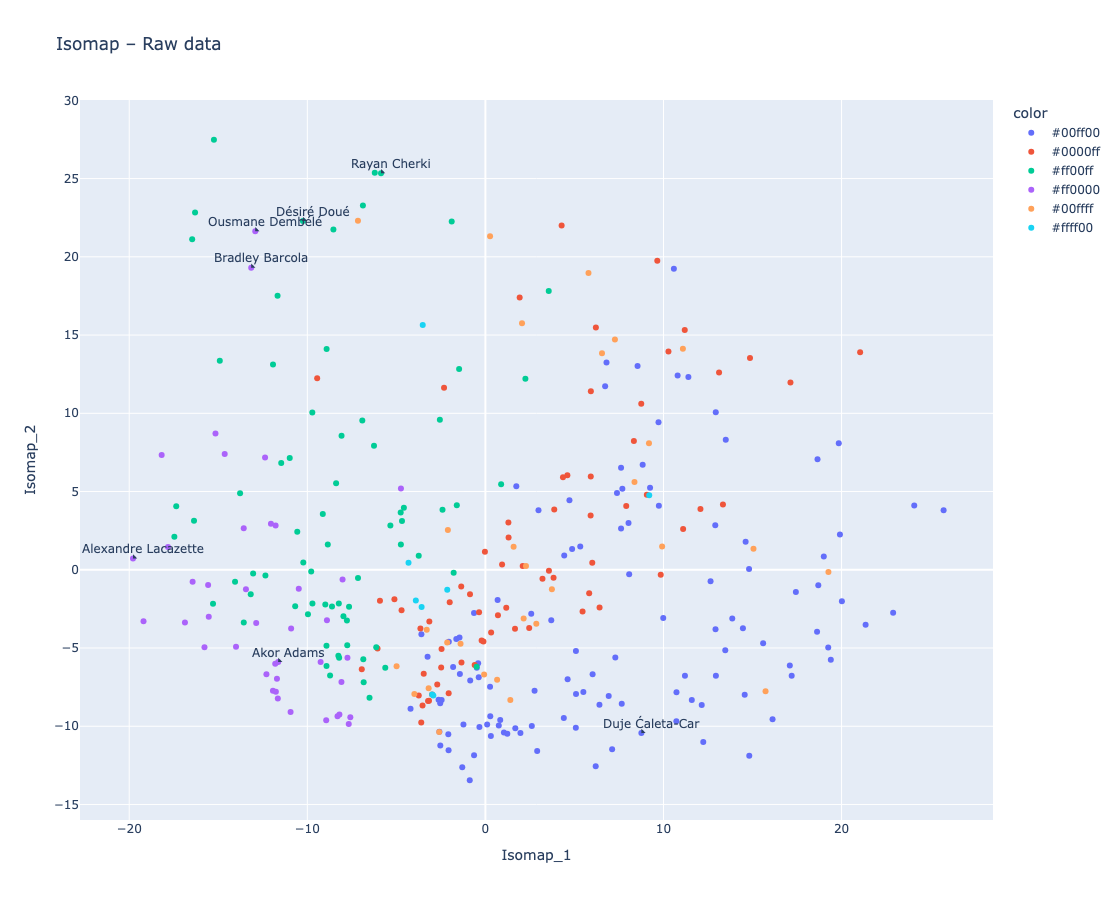

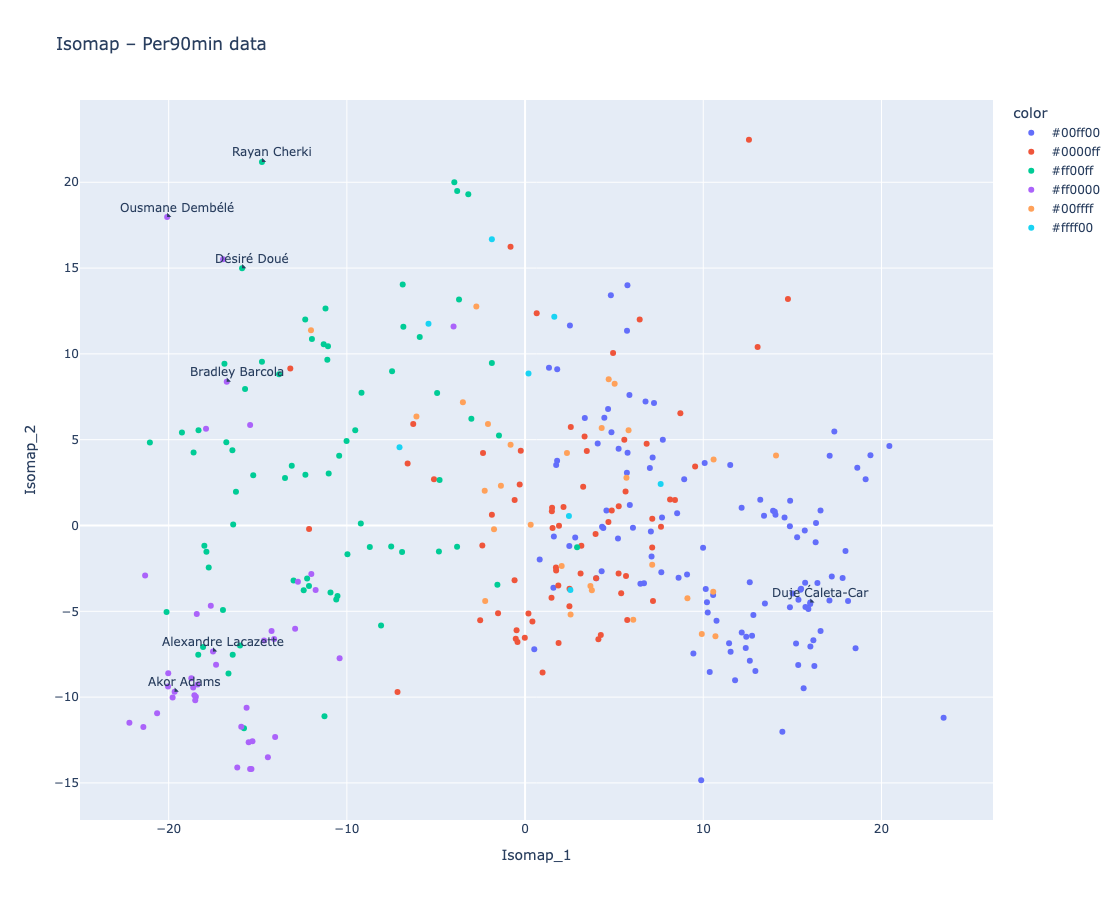

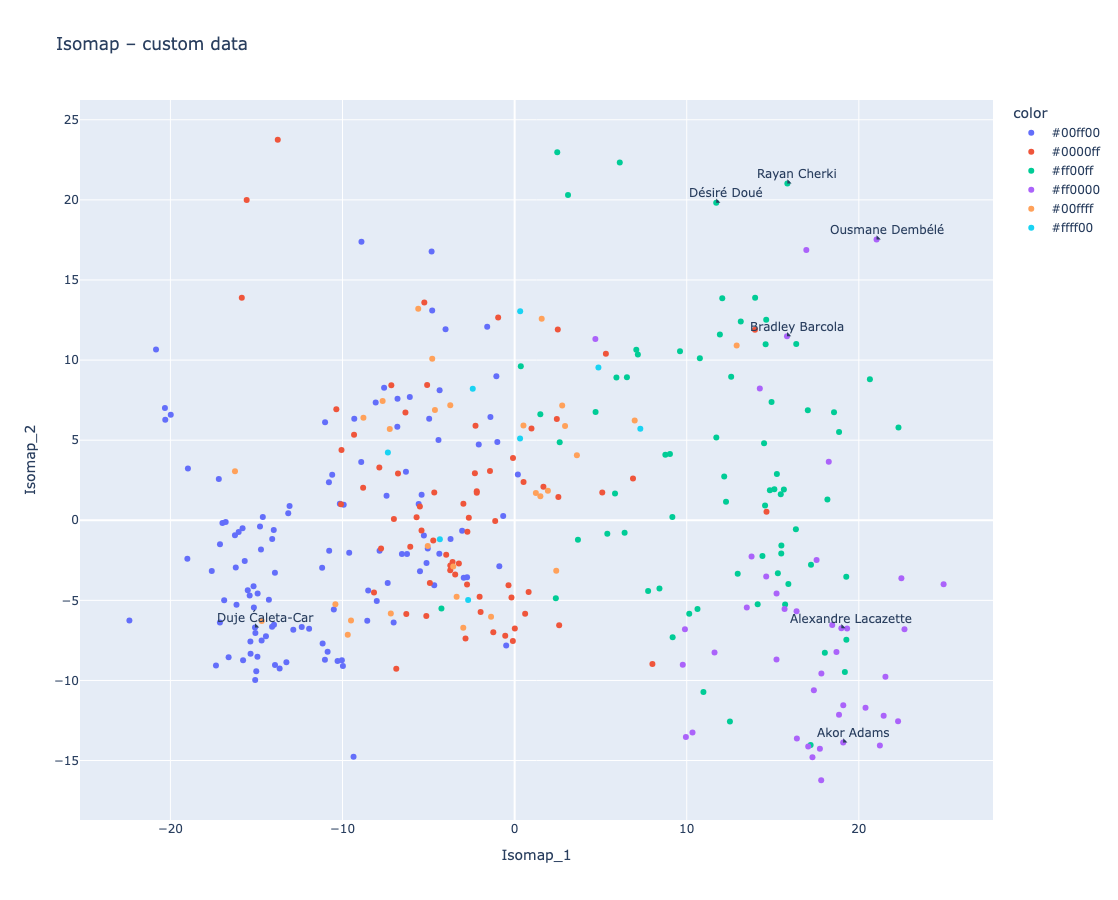

==== Raw data perf : ====
Dist correlation : 0.942970818297958
Trustworthiness : 0.9686543236149535
Continuity : 0.9905956350050839
MRRE : 0.29770561759377406
==== Per90 data perf : ====
Dist correlation : 0.8920619407279958
Trustworthiness : 0.9591024094961103
Continuity : 0.9898124896550093
MRRE : 0.3565230935295638
==== Custom data perf : ====
Dist correlation : 0.8929168015035457
Trustworthiness : 0.9467584119552623
Continuity : 0.9890719065522215
MRRE : 0.3864179947349087


In [17]:
position_colors = {
    'FW': np.array([255, 0, 0]),    # red
    'MF': np.array([0, 0, 255]),    # blue
    'DF': np.array([0, 255, 0]),  #  yellow
    'GK' : np.array([255, 255, 255]),
}

players_to_label = [
    "rayan cherki", "ousmane dembélé", "désiré doué", 
    "bradley barcola", "alexandre lacazette", "akor adams", "Duje Ćaleta-Car"
]

def color_from_position(positions):
    postitions = str(positions)
    position_list = positions.split(',')
    colors = np.array([position_colors[p] for p in position_list if p in position_colors])
    avg_color = np.sum(colors, axis=0)
    return '#%02x%02x%02x' % tuple(avg_color.astype(int))

def plot_isomap_interactive(X_iso, player_positions, data_num, title):
    df_plot = pd.DataFrame({
        'Isomap_1': X_iso[:, 0],
        'Isomap_2': X_iso[:, 1],
        'player_name': data_num.index,
        'color' : player_positions.apply(color_from_position)
    })
    
    fig = px.scatter(
        df_plot,
        x='Isomap_1', y='Isomap_2',
        hover_name='player_name',
        color='color',
        title=title,
        height=900, width=1100 
    )

    for i, row in df_plot.iterrows():
        if row['player_name'].lower() in [p.lower() for p in players_to_label]:
            fig.add_annotation(
                x=row['Isomap_1'],
                y=row['Isomap_2'],
                text=row['player_name'],
                showarrow=True,
                arrowhead=1,
                ax=10, ay=-10
            )
            
    if title == "Isomap – Raw data" : 
        fig.write_image("isomap_raw.png")
    fig.show()

plot_isomap_interactive(X_iso_raw, player_positions_raw ,data_raw.set_index("player_name"), "Isomap – Raw data")
plot_isomap_interactive(X_iso_per90, player_positions_per90 ,data_per90.set_index("player_name"), "Isomap – Per90min data")
plot_isomap_interactive(X_iso_custom, player_positions_custom ,data_custom.set_index("player_name"), "Isomap – custom data")

_, _, corr_raw, _, trust_raw, cont_raw, mrre_raw = extractMetrics(iso_raw, X_raw, X_iso_raw)
_, _, corr_per90, _, trust_per90, cont_per90, mrre_per90 = extractMetrics(iso_per90, X_per90, X_iso_per90)
_, _, corr_custom, _, trust_custom, cont_custom, mrre_custom = extractMetrics(iso_custom, X_custom, X_iso_custom)

print("==== Raw data perf : ====")
print(f"Dist correlation : {corr_raw}")
print(f"Trustworthiness : {trust_raw}")
print(f"Continuity : {cont_raw}")
print(f"MRRE : {mrre_raw}")

print("==== Per90 data perf : ====")
print(f"Dist correlation : {corr_per90}")
print(f"Trustworthiness : {trust_per90}")
print(f"Continuity : {cont_per90}")
print(f"MRRE : {mrre_per90}")

print("==== Custom data perf : ====")
print(f"Dist correlation : {corr_custom}")
print(f"Trustworthiness : {trust_custom}")
print(f"Continuity : {cont_custom}")
print(f"MRRE : {mrre_custom}")      